# Calculating Influence Diagrams of Beams

We will calculate influence diagrams for a Timoshenko beam of a constant, rectangular cross section. For plotting, we will use ``Matplotlib``.

## Setting up the model

In [62]:
from sigmaepsilon.solid.fourier import NavierBeam

# geometry
beam_length = 1000.0
width, height = 20.0, 80.0  # rectangular cross-section

# material properties
young_modulus, poisson_ratio = 210000.0, 0.25  # material
area = width * height
shear_modulus = young_modulus / (2 * (1 + poisson_ratio))

# stiffness properties
inertia = width * height**3 / 12
bending_stiffness = young_modulus * inertia
shear_correction_factor = 5 / 6
shear_stiffness = shear_modulus * area * shear_correction_factor

# solution parameters
number_of_modes = 100

beam = NavierBeam(
    beam_length, number_of_modes, EI=bending_stiffness, GA=shear_stiffness
)

## Calculation

There are two possible strategies to follow here. One is to create a bunch of load cases, store them in a ``LoadGroup`` and then call the solver once. The other way around is to call the solver multiple times, for each separate load case. We will follow the second approach here.

The location of the cross section for which the influence diagrams are calculated is stored in the variable `evaluation_point`.

We only calculate influence diagrams for a unit vertical load.

In [63]:
from sigmaepsilon.solid.fourier import LoadGroup, PointLoad
import numpy as np

# the location of the cross-section of which the infleunce diagrams are calculated
evaluation_point = np.array([beam_length/3])

number_of_loads = 100
solutions = []
load_positions = []
for i in range(number_of_loads):
    load_position = beam_length *  i / (number_of_loads - 1)
    beam_loads = LoadGroup(LC=PointLoad(load_position, [1.0, 0.0]))
    solution = beam.linear_static_analysis(evaluation_point, beam_loads)
    solutions.append(solution["LC"].to_xarray())
    load_positions.append(load_position)

## Plotting with ``Matplotlib``

Plotting with ``Matplotlib`` is pretty straightforward. The only thing that might set you off is that we use ``LaTeX`` for better typesetting of our variables.

For every subplot, we plot a vertical line at the location of the cross-section for which the influence diagrams are calculated.

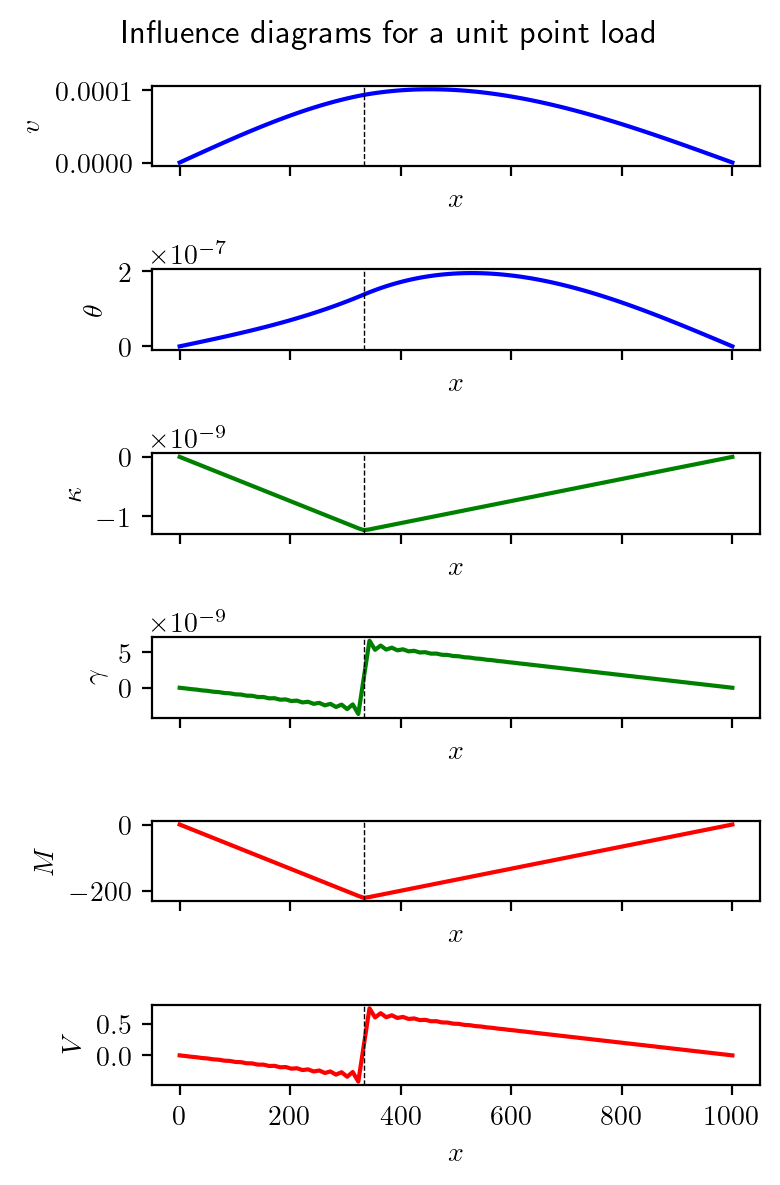

In [66]:
from sigmaepsilon.solid.fourier import BeamLoadCaseResultLinStat
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 1, figsize=(4, 6), dpi=200, sharex=True)

labels = [r"$v$", r"$\theta$", r"$\kappa$", r"$\gamma$", r"$M$", r"$V$"]
colors = ["b", "b", "g", "g", "r", "r"]
components = BeamLoadCaseResultLinStat.components

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
    }
)
for i in range(6):
    component = components[i]
    data = [float(s.loc[0, component].values) for s in solutions]
    axs[i].plot(load_positions, data, colors[i])
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel(labels[i])
    axs[i].axvline(x=evaluation_point, color='black', linestyle='dashed', lw=0.5)

fig.suptitle("Influence diagrams for a unit point load")
plt.subplots_adjust(hspace=0.1)
fig.tight_layout()